# 1 Logistic Regression 
We will build a logistic regression model to predict whether a student gets admitted into a university.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

In [4]:
file_location = 'data/ex2data1.txt'
df = pd.read_csv(file_location, names=['exam1 score','exam2 score','admissions decision'])
df.head()

,exam1 score,exam2 score,admissions decision
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


## 1.1 Visualizing the data 

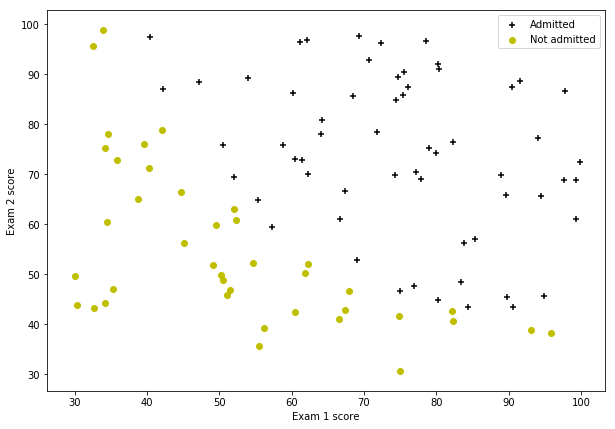

In [3]:
X = df.as_matrix(columns=['exam1 score','exam2 score'])
X = np.insert(X,0,1,axis=1)
y = df.as_matrix(columns=['admissions decision'])
m = y.shape[0] # number of training examples
n = X.shape[1] # number of features

pos = (y==1).flatten() # convert 2-dimention array into 1-dimension array
neg = (y==0).flatten()

def plotData():
    plt.figure(figsize=(10,7))
    plt.scatter(X[pos,1], X[pos,2], c='k', marker='+', label='Admitted')
    plt.scatter(X[neg,1], X[neg,2], c='y', marker='o', label='Not admitted')
    plt.xlabel('Exam 1 score')
    plt.ylabel('Exam 2 score')

plotData()
plt.legend(loc='best')
plt.show()

## 1.2 Implementation 
### 1.2.1 Warmup exercise: sigmoid function ##

In [4]:
def sigmoid(z):
    return 1/(1+np.exp(-z))
sigmoid(0)

0.5

### 1.2.2 Cost function and gradient

In [5]:
def costFunction(theta,X,y,_lambda): # theta must be put in the first position of argument, for 'optimizer' below
    h = sigmoid(X.dot(theta))
    J = -float((np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y)))/m + _lambda*np.sum(theta[1:]**2)/(2*m)  # vectorization version is better  
    return J

def gradientDescent(theta,X,y,_lambda):
    h = sigmoid(X.dot(theta))
    grad = X.T.dot(h-y)/m
    grad[1:] += (_lambda/m) * theta[1:] 
    return grad.flatten()

theta=np.zeros((n,1))
_lambda = 0. # we dont need to regularize costFunction here, so set lambda=0.  
J = costFunction(theta,X,y,_lambda)
grad = gradientDescent(theta,X,y,_lambda)
print('cost: \n',J)
print('gradient: \n',grad)

cost: 
 0.6931471805599452
gradient: 
 [ -0.1        -12.00921659 -11.26284221]


### 1.2.3 Learning parameters using 'scipy.optimize.minimize'
Optimization solver built-in function in Octave/- MATLAB is called fminunc, we use scipy.optimize.fmin in Python

https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.optimize.fmin.html

In [6]:
def optimizer(theta, X, y, _lambda):  # theta must be put in the first position of argument
    res = optimize.fmin(costFunction, x0=theta, args=(X, y, _lambda),
                        maxiter=400, full_output=True)
    return res[0], res[1] # res[0]:Parameter that minimizes function = theta
                          # res[1]:Value of function at minimum      = cost   

theta_final, cost_final = optimizer(theta,X,y,_lambda)
print('cost: \n',cost_final)
print('theta: \n',theta_final)

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 157
         Function evaluations: 287
cost: 
 0.20349770159021519
theta: 
 [-25.16130062   0.20623142   0.20147143]


**plot Decision Boundary**

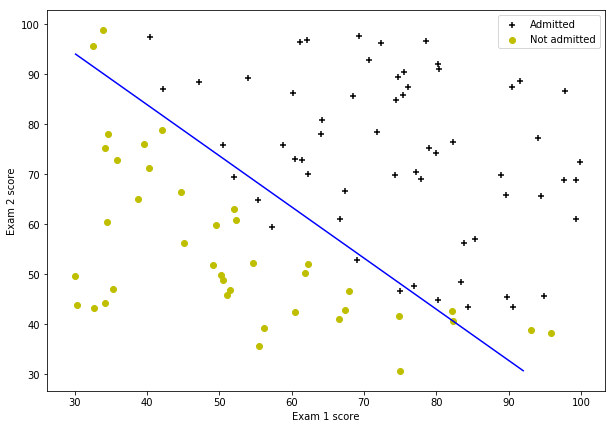

In [7]:
def plotBoundary(X,theta,mapfeature=False):
    x1_min, x1_max = X[:,1].min(), X[:,1].max()
    x2_min, x2_max = X[:,2].min(), X[:,2].max()
    x_vals, y_vals = np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max)
    xx, yy = np.meshgrid(x_vals,y_vals)
    zz = np.zeros(xx.shape)
    for i,x1 in enumerate(x_vals):
        for j,x2 in enumerate(y_vals):
            if mapfeature:
                features = mapFeature(np.array([[1,x1,x2]]))
                zz[i,j] = sigmoid(theta.dot(features.T))                
            else:
                zz[i,j] = sigmoid(theta.dot([1,x1,x2]))
    zz = zz.T

    plotData()
    plt.contour(xx, yy, zz, [0.5], colors='b') # regions are divided by 0.5

plotBoundary(X,theta_final)
plt.legend(loc='best')
plt.show()

### 1.2.4 Evaluating logistic regression 

In [8]:
def admissionProbability(array):
    prob = sigmoid(theta_final.dot(array))
    return prob
admissionProbability([1.,45.,85.])

0.7762915904112411

In [9]:
def predict(array):
    return admissionProbability(array)>=0.5 

true_positive = [predict(array) for array in X[pos,:]].count(1)
true_negative = [predict(array) for array in X[neg,:]].count(0)
total = m
accurancy = float(true_positive+true_negative)/total
accurancy

0.89

# 2 Regularized logistic regression
We will implement regularized logistic regression to predict whether microchips 
from a fabrication plant passes quality assurance (QA).

In [10]:
file_location = 'ex2/ex2data2.txt'
df = pd.read_csv(file_location, names=['Microchip Test 1','Microchip Test 2','admissions decision'])
df.head()

,Microchip Test 1,Microchip Test 2,admissions decision
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


## 2.1 Visualizing the data 

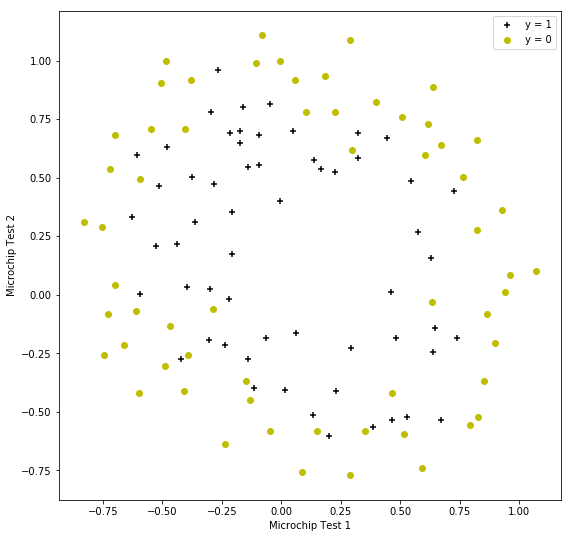

In [11]:
X = df.as_matrix(columns=['Microchip Test 1','Microchip Test 2'])
X = np.insert(X,0,1,axis=1)
y = df.as_matrix(columns=['admissions decision'])
m = y.shape[0] # number of training examples
n = X.shape[1] # number of features

# convert 2-dimension array into 1-dimension array
pos = (y==1).flatten() 
neg = (y==0).flatten()

def plotData():
    plt.figure(figsize=(9,9))
    plt.scatter(X[pos,1], X[pos,2], c='k', marker='+', label='y = 1')
    plt.scatter(X[neg,1], X[neg,2], c='y', marker='o', label='y = 0')
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')

plotData()
plt.legend(loc='best')
plt.show()

## 2.2 Feature mapping 
Two features are not enough for plotting non-linear decision boundary, so we have to create more features! 

In [12]:
def mapFeature(X):
    degree = 6
    x1, x2 = X[:,1], X[:,2]
    x1.shape, x2.shape = (x1.size,1), (x2.size,1)
    x = np.ones(x1.shape)
    for i in range(1,degree+1):  # there already are 1,x**1 and x**2 in X. so i begains with 2
        for j in range(i+1):
            x = np.append(x, x1**(i-j) * x2**j, axis=1)
    return x

X = mapFeature(X)
X.shape

(118, 28)

## 2.3 Cost function and gradient 
Although the feature mapping allows us to build a more expressive classifier, it also more susceptible to overfitting.
Regularization can help combat the overfitting problem.

In [13]:
theta=np.zeros((X.shape[1],1))
_lambda=1.
J = costFunction(theta,X,y,_lambda)
grad = gradientDescent(theta,X,y,_lambda)
print('cost: \n',J)
print('gradient: \n',grad[:5])

cost: 
 0.6931471805599453
gradient: 
 [8.47457627e-03 1.87880932e-02 7.77711864e-05 5.03446395e-02
 1.15013308e-02]


### 2.3.1 Learning parameters using optimizer 
If we continue using the optimizer above (which use optimize.fmin),  
it indicates that 'Warning: Maximum number of iterations has been exceeded'.
Thus, we use optimize.minimize to define a new function 'optimizer2'

In [14]:
def optimizer2(theta, x, y, _lambda):  # theta must be put in the first position of argument
    res = optimize.minimize(costFunction, theta, args=(X,y,_lambda), method='BFGS', options={'maxiter':400})
    print(res.message)
    return res.x, res.fun # res.x :The solution of the optimization = theta
                          # res.fun:Values of objective function    = cost

## 2.4 Plotting the decision boundary 

Optimization terminated successfully.


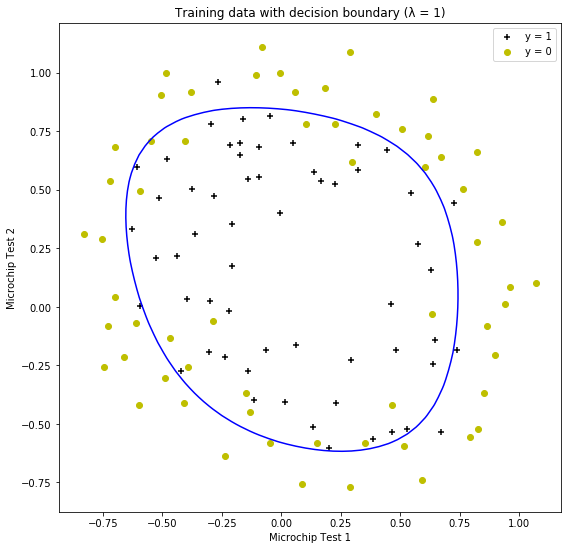

In [15]:
theta1, cost1 = optimizer2(theta,X,y,_lambda=1.)
plotBoundary(X,theta1,mapfeature=True)
plt.legend(loc='best')
plt.title('Training data with decision boundary (λ = 1)')
plt.show()

Maximum number of iterations has been exceeded.


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


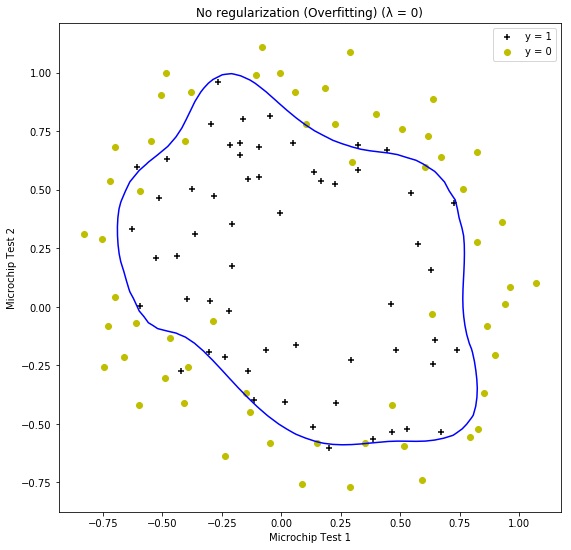

In [16]:
theta2, cost2 = optimizer2(theta,X,y,_lambda=0.)
plotBoundary(X,theta2,mapfeature=True)
plt.legend(loc='best')
plt.title('No regularization (Overfitting) (λ = 0)')
plt.show()

Optimization terminated successfully.


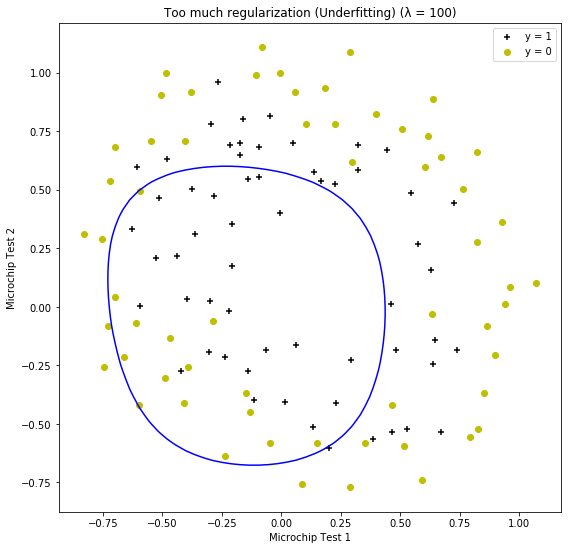

In [17]:
theta3, cost3 = optimizer2(theta,X,y,_lambda=100.)
plotBoundary(X,theta3,mapfeature=True)
plt.legend(loc='best')
plt.title('Too much regularization (Underfitting) (λ = 100)')
plt.show()